![Banner](/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/img/BannerEN.png)

# **Musculoskeletal Radiograph Classification (MURA)**

This project aims to develop a **binary classification model** capable of identifying whether a musculoskeletal radiograph (from the [MURA dataset](https://stanfordmlgroup.github.io/competitions/mura/)) shows an **abnormality (positive)** or is **normal (negative)**.

---

## What will we do?

1. **Prepare the data** from the MURA image dataset.
2. **Build a model based on a pretrained ResNet18**, adapted for binary classification.
3. **Train the model** using fine-tuning techniques on radiographic images.
4. **Evaluate performance** using metrics such as F1-score, accuracy, and confusion matrix.
5. **Visualize correct and incorrect predictions** to interpret model behavior.
6. **Save the final model** for future use.

## **Step 1: Imports and Required Libraries**

We begin by loading all the necessary libraries for image processing, modeling with PyTorch, visualization, and evaluation.

In [1]:
# Block 1 – Imports and Device Configuration

# Standard libraries
import os
import random
from pathlib import Path
from collections import Counter

# Scientific packages
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

# Evaluation metrics and visualization
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns

# Device configuration (CPU / GPU / MPS for Apple Silicon)
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print(f"Running on: {DEVICE}")

Running on: mps


## Step 2: Hyperparameter Definition

In this block, we define the path to the dataset (stored locally due to its size), the image size, batch size, number of epochs, learning rate, and other key hyperparameters such as `early stopping` patience and the learning rate `scheduler`. We also set a random seed to ensure experiment reproducibility.

In [2]:
# Block 2 – Hyperparameters and Configuration

# Path to the full dataset (stored locally due to size)
DATASET_DIR = "/Users/alvarosanchez/Downloads/MURA-v1.1"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VALID_DIR = os.path.join(DATASET_DIR, "valid")

# Increased image size to enhance feature extraction capacity
IMAGE_SIZE = 256  # Previously 224

# Batch size
BATCH_SIZE = 32

# Number of training epochs
NUM_EPOCHS = 20

# Base learning rate
LEARNING_RATE = 1e-4  # Lowered for more stable fine-tuning

# Patience settings for early stopping and learning rate scheduler
EARLYSTOP_PATIENCE = 5
LR_PATIENCE = 5

# Learning rate reduction factor
LR_FACTOR = 0.5

# Number of output classes (binary classification)
NUM_CLASSES = 2

# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

- `IMAGE_SIZE` increased to 256×256 → improves resolution to capture finer bone details.

- `LEARNING_RATE` lowered to 1e-4 → allows better control during fine-tuning of the pretrained model.

- `EARLYSTOP_PATIENCE` and `LR_PATIENCE` both set to 5 → ensures consistent and stable training dynamics.

## Step 3: Preprocessing and Data Loading

This block defines the image transformations to be applied (data augmentation for training, normalization for validation), creates a custom dataset to classify images as `positive` (abnormal) or `negative` (normal), and loads the data into `DataLoaders`. This enables efficient batch processing and leverages augmentation techniques to improve generalization.

In [3]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Training transformations with enhanced data augmentation
transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize image
    transforms.RandomHorizontalFlip(p=0.5),       # Random horizontal flip
    transforms.RandomRotation(degrees=15),        # Random rotation to simulate different angles
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random brightness and contrast
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.85, 1.0)),  # Random zoom and crop
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],         # Normalize using ImageNet statistics
                         std=[0.229, 0.224, 0.225])
])

# Validation transformations (no augmentation)
transform_val = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Only resize and normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom dataset that ignores invalid files and assigns binary labels
class MURABinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        root_path = Path(root_dir)
        for part_dir in root_path.iterdir():
            if part_dir.is_dir():
                for patient_dir in part_dir.iterdir():
                    if patient_dir.is_dir():
                        for study_dir in patient_dir.iterdir():
                            label = 1 if "positive" in study_dir.name.lower() else 0
                            for img_path in study_dir.glob("*.png"):
                                self.samples.append((str(img_path), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load datasets
train_dataset = MURABinaryDataset(TRAIN_DIR, transform=transform_train)
valid_dataset = MURABinaryDataset(VALID_DIR, transform=transform_val)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

Aggressive but appropriate augmentations have been applied for medical imaging: rotation, zoom, brightness adjustment, and random cropping. These are intended to improve the model's generalization capabilities.

The custom dataset is well implemented: it filters for `.png` images and automatically labels each sample based on the study folder name. 

Using `shuffle=True` during training is the correct approach to prevent order-based bias.

Corrupted or non-image files (e.g., `.DS_Store`) are implicitly ignored by the dataset structure.

## Class Imbalance Analysis (Training Set)

Before training the model, it is essential to analyze the class distribution in the dataset. A strong imbalance between classes (e.g., significantly more normal images than abnormal ones) can lead the model to become biased and learn to always predict the majority class.

To mitigate this, we will use a **weighted loss function** (`CrossEntropyLoss`) with **class weights inversely proportional to their frequency** in the training set.

Negative: 21935 images
Positive: 14873 images


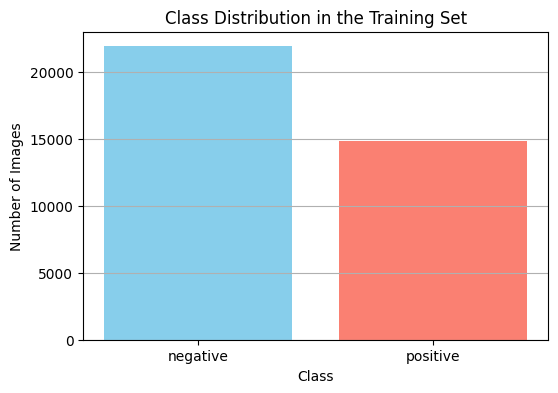

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract labels from the training dataset
train_labels = [label for _, label in train_dataset]

# Count how many images there are per class
label_counts = Counter(train_labels)
class_names = ["negative", "positive"]

# Print the class counts
for i, name in enumerate(class_names):
    print(f"{name.capitalize()}: {label_counts[i]} images")

# Visualize class imbalance
plt.figure(figsize=(6, 4))
plt.bar(class_names, [label_counts[0], label_counts[1]], color=["skyblue", "salmon"])
plt.title("Class Distribution in the Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.show()

As shown in the graph, the dataset exhibits a clear class imbalance, with the `negative` (normal) class being much more frequent than the `positive` (abnormal) class.

This imbalance can cause the model to achieve high accuracy by simply predicting "normal" in most cases, while ignoring positive samples — which are the most critical in a medical context.

To address this, we use a **weighted loss function** (`CrossEntropyLoss(weight=...)`) that penalizes errors on the minority class more heavily, helping the model pay closer attention to abnormal images.

## Class Imbalance Analysis (Validation Set)

It is also useful to check whether the validation set has a class imbalance similar to the training set. If the imbalance is significantly different, the model’s ability to generalize may be negatively affected.

Below is a chart showing the class distribution in the validation set.

Negative (validation): 1667 images
Positive (validation): 1530 images


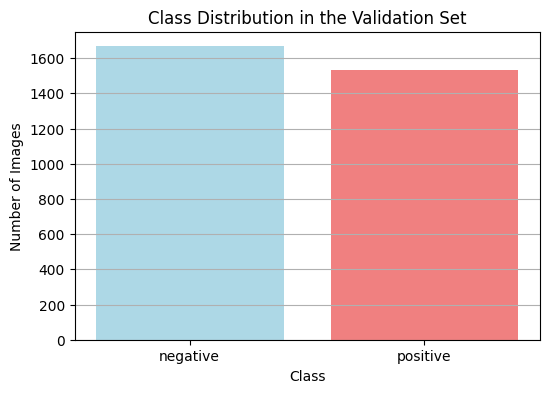

In [5]:
# Extract labels from the validation dataset
valid_labels = [label for _, label in valid_dataset]

# Count how many images there are per class
valid_label_counts = Counter(valid_labels)
class_names = ["negative", "positive"]

# Print the class counts
for i, name in enumerate(class_names):
    print(f"{name.capitalize()} (validation): {valid_label_counts[i]} images")

# Visualize class imbalance
plt.figure(figsize=(6, 4))
plt.bar(class_names, [valid_label_counts[0], valid_label_counts[1]], color=["lightblue", "lightcoral"])
plt.title("Class Distribution in the Validation Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.show()

The validation set also shows a **significant class imbalance** between `negative` and `positive` samples, although possibly less pronounced than in the training set.

This behavior is common in real-world medical datasets, where abnormal (positive) cases are naturally rarer. It's important to consider this because:

- A more balanced validation set may provide a fairer evaluation of the model.
- Using F1-score as the main evaluation metric is especially relevant here, as it **penalizes poor sensitivity** toward the minority class.
- Ensuring that the model performs well on both classes is crucial for clinical reliability.

In summary, this observation reinforces the decision to use a **weighted loss function** and robust evaluation metrics such as F1-score when assessing the model.

## Step 4: Load ResNet18 Model and Fine-Tuning Setup

We load a `ResNet18` model pretrained on ImageNet and perform **partial fine-tuning** by unfreezing only the deeper layers (`layer2`, `layer3`, `layer4`, `fc`). The final classification layer is also replaced to adapt the output to two classes: positive (abnormal) and negative (normal).

In [6]:
from torchvision import models
import torch.nn as nn

# Load pretrained ResNet18 model
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all parameters to prevent updates by default
for param in resnet18.parameters():
    param.requires_grad = False

# Selectively unfreeze deeper layers for partial fine-tuning
for name, child in resnet18.named_children():
    if name in ['layer2', 'layer3', 'layer4', 'fc']:
        for param in child.parameters():
            param.requires_grad = True

# Replace the final layer with a new one for binary classification (2 outputs)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 2)

# Send the model to the selected device (MPS, CUDA, or CPU)
resnet18 = resnet18.to(DEVICE)

# Print model architecture
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Layers `layer2`, `layer3`, `layer4`, and `fc` are unfrozen to allow the model to learn dataset-specific features without losing the general knowledge acquired from ImageNet.

This enables effective transfer learning while avoiding overfitting — which could occur if the entire network were unfrozen from the start.

The rest of the network remains frozen to preserve the pretrained feature extraction capabilities.

## Step 5: Training Configuration

This block sets up the key components for training the model: the loss function (`CrossEntropyLoss`), the optimizer (`Adam`), and the learning rate scheduler (`ReduceLROnPlateau`). Class weights are applied to the loss function to compensate for the dataset imbalance between normal and abnormal images.

In [7]:
import torch.optim as optim
import torch.nn as nn

# Class weights to handle dataset imbalance
class_counts = np.bincount([label for _, label in train_dataset])  # Count images per class
total_samples = sum(class_counts)  # Total number of images
class_weights = [total_samples / c for c in class_counts]  # Inversely proportional to class frequency
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)  # Convert to tensor on the selected device

# Loss function with class weights (penalizes minority class errors more)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer: only updates the parameters that were unfrozen
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet18.parameters()), lr=LEARNING_RATE)

# Learning rate scheduler: reduces LR if validation loss doesn't improve after a few epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                  patience=LR_PATIENCE, verbose=True)

print("Training configured. Optimizer, LR Scheduler, and Weighted Loss are active.")

Training configured. Optimizer, LR Scheduler, and Weighted Loss are active.


/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


This block is essential for efficient training. The use of `class_weights` is appropriate, as the MURA dataset contains more normal than abnormal images.

Using `filter(lambda p: p.requires_grad, ...)` ensures that only the unfrozen layers are updated during training.

Finally, `ReduceLROnPlateau` dynamically adjusts the learning rate if no improvement is observed, which helps stabilize the learning process in later training stages.

## Step 6: Model Training

This block performs the full training loop for the model. Loss and metrics (F1-score and accuracy) are computed at each epoch for both the training and validation sets.

Additionally, the best model is saved based on **validation loss**, and **early stopping** is triggered if no improvement is observed for a predefined number of epochs. At the end, the model is reloaded with the optimal weights achieved during training.

In [8]:
from sklearn.metrics import f1_score, accuracy_score
import copy

# Save a copy of the initial model weights
best_model_wts = copy.deepcopy(resnet18.state_dict())

# Initialize the best validation loss as infinity
best_val_loss = float("inf")

# Counter for early stopping
epochs_no_improve = 0

print("Training begins...")

# Training loop by epoch
for epoch in range(NUM_EPOCHS):
    # === TRAINING ===
    resnet18.train()  # Set model to training mode
    train_loss = 0.0
    y_train_true, y_train_pred = [], []

    # Iterate through training batches
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()  # Reset gradients
        outputs = resnet18(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item() * inputs.size(0)  # Accumulate loss
        y_train_true.extend(labels.cpu().numpy())  # True labels
        y_train_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())  # Predicted labels

    avg_train_loss = train_loss / len(train_loader.dataset)  # Average training loss

    # === VALIDATION ===
    resnet18.eval()  # Evaluation mode (disables dropout and batchnorm)
    val_loss = 0.0
    y_val_true, y_val_pred = [], []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            y_val_true.extend(labels.cpu().numpy())
            y_val_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)  # Average validation loss

    # === METRICS ===
    train_f1 = f1_score(y_train_true, y_train_pred, average='weighted')  # Training F1-score
    val_f1 = f1_score(y_val_true, y_val_pred, average='weighted')        # Validation F1-score
    val_acc = accuracy_score(y_val_true, y_val_pred)                     # Validation accuracy

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    # Scheduler step (adjust learning rate if no improvement)
    scheduler.step(avg_val_loss)

    # === EARLY STOPPING and best model saving ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss  # Update best validation loss
        best_model_wts = copy.deepcopy(resnet18.state_dict())  # Save model weights
        torch.save(
            resnet18.state_dict(),
            "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_fulldata_optimizado_EN.pt"
        )
        epochs_no_improve = 0
        print("Best model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLYSTOP_PATIENCE:
            print("Early stopping activated.")
            break

# Load the best model weights after training
resnet18.load_state_dict(best_model_wts)

Training begins...
Epoch 1 | Train Loss: 0.5383 | Val Loss: 0.5449 | Acc: 0.7729 | F1: 0.7665
Best model saved.
Epoch 2 | Train Loss: 0.4779 | Val Loss: 0.4900 | Acc: 0.7848 | F1: 0.7807
Best model saved.
Epoch 3 | Train Loss: 0.4584 | Val Loss: 0.4571 | Acc: 0.8004 | F1: 0.7997
Best model saved.
Epoch 4 | Train Loss: 0.4413 | Val Loss: 0.5001 | Acc: 0.8079 | F1: 0.8054
Epoch 5 | Train Loss: 0.4289 | Val Loss: 0.4877 | Acc: 0.7948 | F1: 0.7918
Epoch 6 | Train Loss: 0.4166 | Val Loss: 0.4914 | Acc: 0.7961 | F1: 0.7924
Epoch 7 | Train Loss: 0.4049 | Val Loss: 0.6348 | Acc: 0.7760 | F1: 0.7684
Epoch 8 | Train Loss: 0.3917 | Val Loss: 0.4960 | Acc: 0.7982 | F1: 0.7955
Early stopping activated.


<All keys matched successfully>

Overall good performance: F1-score > 0.79 sustained across multiple epochs.

The model reaches its best performance in epoch 3:
Val Loss: 0.4571 | Accuracy: 80.04% | F1-score: 0.7997

The model is not overfitting significantly (training and validation loss remain relatively close up to epoch 5–6).

Validation loss starts to increase from epoch 4, although F1-score also rises during that epoch — which can happen if class balance improves.

In epoch 7, there's a clear negative spike in validation loss (0.6348), possibly due to data noise or lack of regularization.

Early stopping is triggered correctly at epoch 8, preventing the model from continuing inefficient training or overfitting further.

## Step 7: Final Model Evaluation and Error Analysis

This block evaluates the final model on the validation set. It generates the main performance metrics (accuracy, precision, recall, F1-score), builds a confusion matrix to visualize correct and incorrect predictions, and displays misclassified images to help identify common patterns or failure cases in the model’s predictions.


Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.85      0.82      1667
    positive       0.82      0.75      0.78      1530

    accuracy                           0.80      3197
   macro avg       0.80      0.80      0.80      3197
weighted avg       0.80      0.80      0.80      3197



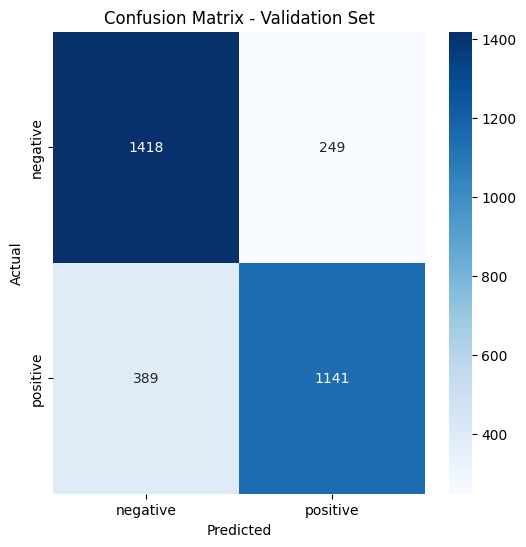


Displaying 9 misclassified images:


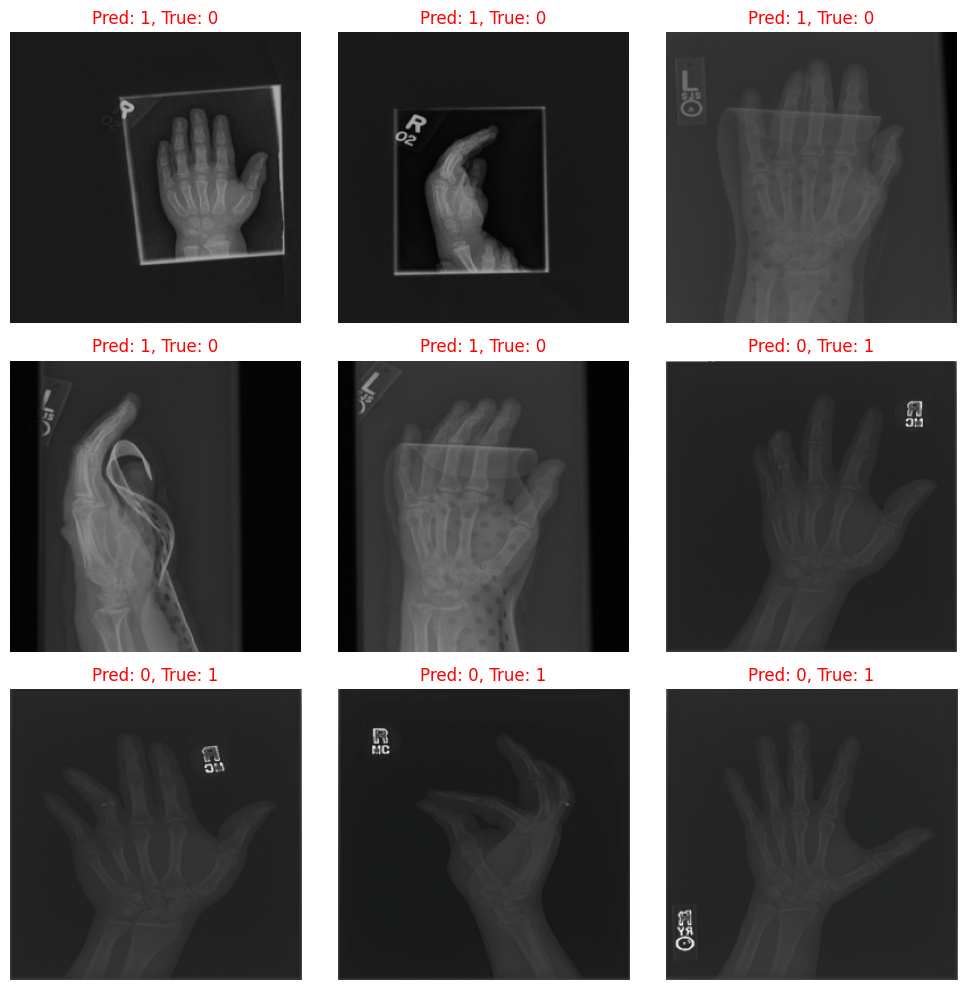

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
resnet18.eval()

# Lists to store true and predicted labels
y_true = []
y_pred = []
images_list = []  # List to store input images for later visualization

# Disable gradient calculation for evaluation (saves memory and time)
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = resnet18(inputs)  # Forward pass
        preds = torch.argmax(outputs, dim=1)  # Get the predicted class

        y_true.extend(labels.cpu().numpy())   # Store true labels
        y_pred.extend(preds.cpu().numpy())    # Store predicted labels
        images_list.extend(inputs.cpu())      # Store images for visual error analysis

# Classification report: precision, recall, F1-score, and accuracy per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

# Confusion matrix to visualize correct vs incorrect predictions
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["negative", "positive"],
            yticklabels=["negative", "positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Set")
plt.show()

# Identify indices of misclassified images
misclassified_idxs = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]

print(f"\nDisplaying {min(9, len(misclassified_idxs))} misclassified images:")
plt.figure(figsize=(10, 10))

# Visualize up to 9 misclassified images
for i, idx in enumerate(misclassified_idxs[:9]):
    image = images_list[idx].permute(1, 2, 0).numpy()  # Rearrange dimensions for visualization
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # Denormalize
    image = np.clip(image, 0, 1)  # Clamp values to [0, 1] range

    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    color = "red"
    if y_true[idx] == y_pred[idx]:
        color = "green"
    plt.title(f"Pred: {y_pred[idx]}, True: {y_true[idx]}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

Precision (positive): 82% → out of all the times the model predicts an abnormality, it's correct 82% of the time.

Recall (positive): 75% → the model successfully identifies 75% of the abnormal radiographs.

F1-score (positive): 0.78 → a good balance between precision and recall for the most critical class.

Weighted average F1-score: 0.80 → solid overall performance.

The model correctly identifies 1,141 true positives (successful detection of pathology).

It makes 389 false negatives: abnormal radiographs classified as normal → a clinical risk.

It makes 249 false positives: normal radiographs labeled as abnormal → a tolerable outcome.

The model tends to make more mistakes by failing to detect abnormalities (FN), which is critical in a medical context.
Still, it delivers very decent performance for a first baseline model.

False positives (FP) — Pred: 1, True: 0 — often show visually clean radiographs, but with unusual poses or cropped views that may have confused the model.

False negatives (FN) — Pred: 0, True: 1 — are harder to detect at a glance. Some images appear underexposed or contain overlapping bones, which may obscure real abnormalities.

This suggests the model struggles in the following situations:

Radiographs with poor positioning or irregular cropping

Images with darker lighting or overexposure

Borderline cases where even a human expert might hesitate

## Final Step: Saving the Trained Model

In this step, the trained model is saved persistently using `joblib`. This is useful for loading the model in future sessions, deploying it in production, or integrating it into an API.

We save the `state_dict`, which contains the model’s trained weights. This approach is more efficient and is the standard practice when working with PyTorch models.

In [10]:
import joblib
import os

# Final path where the trained model will be saved
final_model_path = "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_final_model_EN.joblib"

# Save only the model weights (state_dict)
# Joblib efficiently stores binary objects, ideal for production use
joblib.dump(resnet18.state_dict(), final_model_path)

print(f"Model successfully saved at: {final_model_path}")


Model successfully saved at: /Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_final_model_EN.joblib
